In [1]:
suppressMessages(library(survminer))
suppressMessages(library(survival))
suppressMessages(library(forestplot))
suppressMessages(library(ggsci))
suppressMessages(library(dplyr))
suppressMessages(library(adjustedCurves))

## 1. Load Dataset
---

In [12]:
data.df <- read.table("data/processed/AL_with_ccp_03.tsv", sep="\t", header=T, row.names='Code.ID')

# Rename columns
column_mapping <- c("LC.Isotype"="Kappa_or_lambda_PCD", 
                    "BU.Cardiac.Stage"="BU__BNP_based__cardiac_staging",
                    "BMPC.%"="Bone_marrow_plasma_cells____"
                   )

data.df <- data.df %>% rename(!!!column_mapping)

# Filter for time from admission >=0
data.df <- data.df[data.df$time_from_admission>=0,]

# Collapse Race
data.df <- data.df %>%
   mutate(Race = ifelse(Race %in% c('American_Indian_Alaska_Native','Multiracial','Native_Hawaiian_Pacific', 'Unknown/other'), 'Other', Race))

# Fix NULL values
data.df <- data.df %>% mutate(BU.Cardiac.Stage = ifelse(BU.Cardiac.Stage=="", NA, BU.Cardiac.Stage))
data.df <- data.df %>% mutate(Primary_organ = ifelse(Primary_organ=="", NA, Primary_organ))
data.df <- data.df %>% mutate(LC.Isotype = ifelse(LC.Isotype=="", NA, LC.Isotype))

# assign cluster to var
data.df$m02q3_cluster_n <- factor(data.df$m02q3_cluster_n, levels=c("Low","Intermediate","High"))
data.df <- data.df[complete.cases(data.df[,"m02q3_cluster_n"]),]
data.df$m02q4_cluster_n <- factor(data.df$m02q4_cluster_n, levels=c("Low","Intermediate-Low","Intermediate","High"))
data.df$fna3_cluster_n <- factor(data.df$fna3_cluster_n, levels=c("Low","Intermediate","High"))
data.df$BU.Cardiac.Stage <- as.factor(data.df$BU.Cardiac.Stage)

# As Factor
data.df$LC.Isotype <- as.factor(data.df$LC.Isotype)
data.df$Sex <- as.factor(data.df$Sex)
data.df$Race <- as.factor(data.df$Race)
data.df$Era <- as.factor(data.df$Era)

## 2. KM Curves
---

In [13]:
plotSurv <- function(fit, data.df, legend.title, legend.labs, ...){
    p <- ggsurvplot(
        fit,                    
        data = data.df,
        risk.table = TRUE,
        pval = TRUE,
        conf.int = TRUE,
        xlab = "Time (Yr)",
        risk.table.y.text.col = T,
        risk.table.y.text = F,
        legend.title = legend.title,
        legend.labs = legend.labs,
        ...
    )
    
    return(p)
}

In [14]:
pdf("figures/cluster_fna3_km_curve.pdf", h=8, w=6)
fit <- survfit(Surv(time, status) ~ fna3_cluster_n, data=data.df)
plotSurv(fit, data.df, "Subgroup", NULL, palette=c("#62b67d","#69a9c8","#ca4a29"), 
         surv.median.line="v", xlim = c(0, 12), break.time.by=2)
dev.off()

pdf 
  2

In [18]:
pdf("figures/cluster_m02q3_cluster_n_km_curve.pdf", h=8, w=6)
fit <- survfit(Surv(time, status) ~ m02q3_cluster_n, data=data.df)
plotSurv(fit, data.df, "Subgroup", NULL, palette=c("#62b67d","#69a9c8","#ca4a29"), 
         surv.median.line="v", xlim = c(0, 12), break.time.by=2)
dev.off()

pdf 
  2

In [19]:
pdf("figures/cluster_km_curve.pdf", h=8, w=6)
fit <- survfit(Surv(time, status) ~ m02q4_cluster_n, data=data.df)
plotSurv(fit, data.df, "Subgroup", NULL, palette=c("#62b67d","#69a9c8","#9F78AA","#ca4a29"), 
         surv.median.line="v", xlim = c(0, 12), break.time.by=2)
dev.off()

pdf 
  2

## 3. Cox Regressions
---

In [20]:
# Baseline Model
mod.baseline <- coxph(Surv(time_from_admission, status) ~ Age + Sex + Race + strata(Era) + LC.Isotype, data=data.df)
cox.zph(mod.baseline)

             chisq df       p
Age        26.6418  1 2.4e-07
Sex         0.0413  1   0.839
Race        4.1336  3   0.247
LC.Isotype  4.8448  1   0.028
GLOBAL     33.9816  6 6.8e-06

In [21]:
# We note that Amyloidogenic light chain & age are time-varying
mod.baseline.t <- coxph(Surv(time_from_admission, status) ~ Age + tt(Age) + Sex + Race + strata(Era) + strata(LC.Isotype), 
                data=data.df, tt=function(x,t,...) x * log(t))

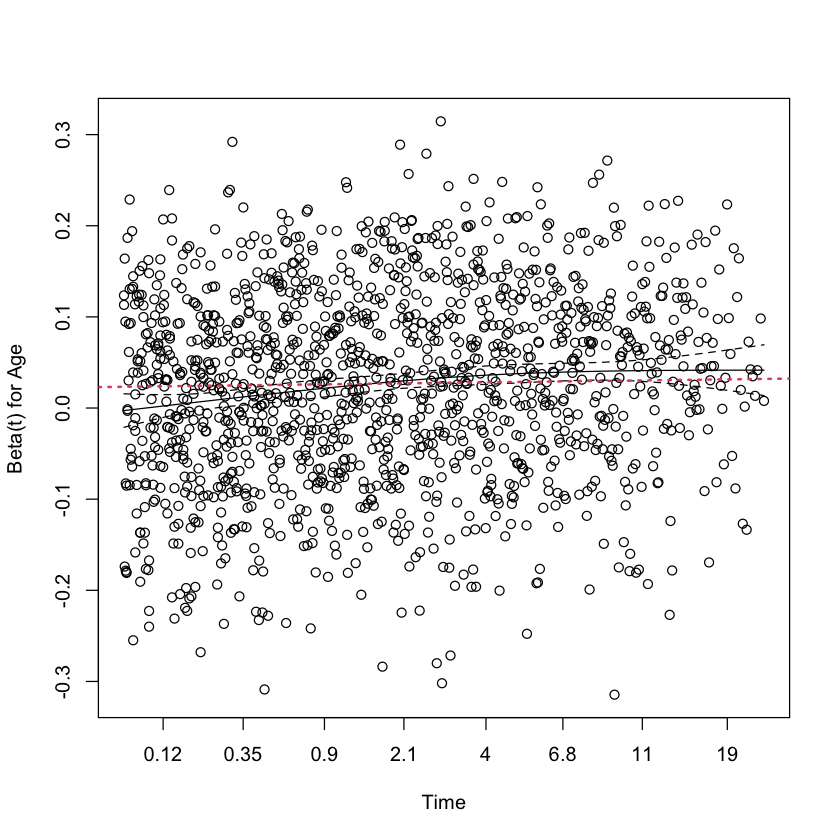

In [22]:
plot(cox.zph(mod.baseline)[1])
abline(coef(mod.baseline.t)[1:2], lwd=2, lty=3, col=2)

In [33]:
data.df$cluster <- data.df$fna3_cluster_n

In [34]:
# Baseline + Cluster
mod.cluster <- coxph(Surv(time_from_admission, status) ~ cluster + Age + Sex + Race + strata(Era) + strata(LC.Isotype), 
                data=data.df, x=TRUE)
# Baseline + Cluster
mod.cluster.t <- coxph(Surv(time_from_admission, status) ~ cluster + Age + tt(Age) + Sex + Race + strata(Era) + strata(LC.Isotype), 
                data=data.df, tt=function(x,t,...) x * log(t), x=TRUE)

# Baseline + BU Cardiac Stage
mod.bu.t <- coxph(Surv(time_from_admission, status) ~ BU.Cardiac.Stage + Age + tt(Age) + Sex + Race + strata(Era) + strata(LC.Isotype), 
                data=data.df, tt=function(x,t,...) x * log(t), x=TRUE)

# Baseline + Cluster + BU Cardiac Stage
mod.cluster.bu.t <- coxph(Surv(time_from_admission, status) ~ cluster + BU.Cardiac.Stage + Age + tt(Age) + Sex + Race + strata(Era) + strata(LC.Isotype), 
                data=data.df, tt=function(x,t,...) x * log(t), x=TRUE)

In [35]:
mod.cdf <- data.frame(rbind(mod.baseline.t$concordance,mod.cluster.t$concordance, mod.bu.t$concordance, mod.cluster.bu.t$concordance))

mod.cdf$mod <- c("~ Age + tt(Age) + Sex + Race + Era + strata(LC.Isotype)",
                 "~ cluster + Age + tt(Age) + Sex + Race + Era + strata(LC.Isotype)",
                 "~ BU Stage + Age + tt(Age) + Sex + Race + Era + strata(LC.Isotype)",
                 "~ cluster + BU Stage + Age + tt(Age) + Sex + Race + Era + strata(LC.Isotype)"

)
mod.cdf

concordant,discordant,tied.x,tied.y,tied.xy,concordance,std,mod
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
185806,143129,3816,149,2,0.5641275,0.009557254,~ Age + tt(Age) + Sex + Race + Era + strata(LC.Isotype)
209848,119687,1297,150,1,0.6362640,0.009084543,~ cluster + Age + tt(Age) + Sex + Race + Era + strata(LC.Isotype)
80825,30285,345,31,0,0.7267283,0.012578502,~ BU Stage + Age + tt(Age) + Sex + Race + Era + strata(LC.Isotype)
81578,29744,133,31,0,0.7325333,0.012407649,~ cluster + BU Stage + Age + tt(Age) + Sex + Race + Era + strata(LC.Isotype)


In [36]:
summary(mod.cluster.t)

Call:
coxph(formula = Surv(time_from_admission, status) ~ cluster + 
    Age + tt(Age) + Sex + Race + strata(Era) + strata(LC.Isotype), 
    data = data.df, x = TRUE, tt = function(x, t, ...) x * log(t))

  n= 2064, number of events= 1387 
   (7 observations deleted due to missingness)

                        coef exp(coef) se(coef)      z Pr(>|z|)    
clusterIntermediate 0.268512  1.308017 0.062077  4.325 1.52e-05 ***
clusterHigh         0.868841  2.384147 0.073436 11.831  < 2e-16 ***
Age                 0.026678  1.027038 0.002786  9.576  < 2e-16 ***
tt(Age)             0.009500  1.009545 0.001722  5.517 3.45e-08 ***
Sexmale             0.123761  1.131746 0.056253  2.200  0.02780 *  
RaceBlack           0.788712  2.200560 0.267164  2.952  0.00316 ** 
RaceOther           0.768988  2.157581 0.480999  1.599  0.10988    
RaceWhite           0.418497  1.519677 0.253627  1.650  0.09893 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                    exp(coef) ex

## 3b. Cox Regression w/ Lab Values

In [37]:
# Baseline + Cluster
mod.labs <- coxph(Surv(time_from_admission, status) ~ cluster + Age + Sex + Race + strata(Era) + strata(LC.Isotype)
                       + log(Troponin+1) + log(BNP) + log(eGFR) + Albumin + log(X24_hr_UTP+1), 
                data=data.df, tt=function(x,t,...) x * log(t))

In [38]:
cox.zph(mod.labs)

                     chisq df       p
cluster             19.183  2 6.8e-05
Age                  2.619  1  0.1056
Sex                  1.020  1  0.3124
Race                 1.036  3  0.7925
log(Troponin + 1)    8.517  1  0.0035
log(BNP)            31.464  1 2.0e-08
log(eGFR)            0.483  1  0.4870
Albumin              0.620  1  0.4312
log(X24_hr_UTP + 1)  2.657  1  0.1031
GLOBAL              49.430 12 1.8e-06

In [55]:
# BNP is time-varying
mod.labs.t <- coxph(Surv(time_from_admission, status) ~ cluster + Age + Sex + Race + strata(Era) + strata(LC.Isotype)
                       + log(Troponin+1) + log(BNP) + tt(BNP) + log(eGFR) + Albumin + log(X24_hr_UTP+1), 
                data=data.df, tt=function(x,t,...) x * log(t))

In [56]:
coef(mod.labs.t)[9:10]

log(BNP)       tt(BNP) 
 0.4025751513 -0.0002032271

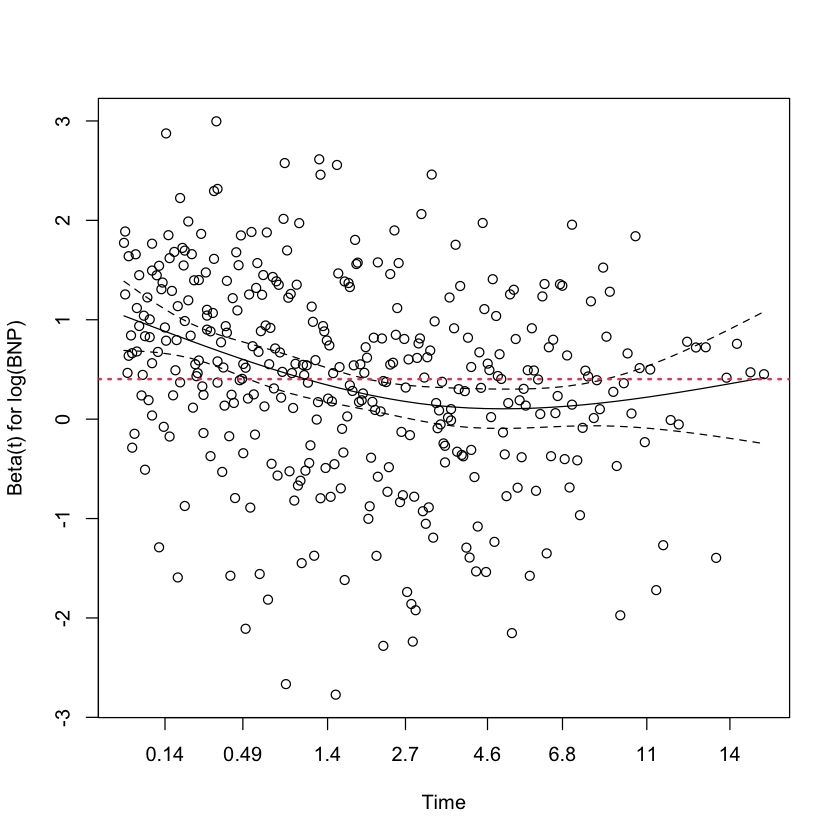

In [57]:
plot(cox.zph(mod.labs)[6])
abline(coef(mod.labs.t)[9:10], lwd=2, lty=3, col=2)

In [58]:
# Renal
mod.renal.labs <- coxph(Surv(time_from_admission, status) ~ cluster + Age + Sex + Race + strata(Era) + strata(LC.Isotype)
                      + log(eGFR) + Albumin + log(X24_hr_UTP+1), 
                data=data.df, tt=function(x,t,...) x * log(t))

In [59]:
cox.zph(mod.renal.labs)

                      chisq df       p
cluster             43.7737  2 3.1e-10
Age                 20.8163  1 5.1e-06
Sex                  0.0685  1    0.79
Race                 5.0892  3    0.17
log(eGFR)            2.2244  1    0.14
Albumin              2.2970  1    0.13
log(X24_hr_UTP + 1)  0.3106  1    0.58
GLOBAL              64.9630 10 4.1e-10

In [60]:
# Renal
mod.renal.labs.t <- coxph(Surv(time_from_admission, status) ~ cluster + Age + tt(Age) + Sex + Race + strata(Era) + strata(LC.Isotype)
                      + log(eGFR) + Albumin + log(X24_hr_UTP+1), 
                data=data.df, tt=function(x,t,...) x * log(t))

In [61]:
summary(mod.renal.labs.t)

Call:
coxph(formula = Surv(time_from_admission, status) ~ cluster + 
    Age + tt(Age) + Sex + Race + strata(Era) + strata(LC.Isotype) + 
    log(eGFR) + Albumin + log(X24_hr_UTP + 1), data = data.df, 
    tt = function(x, t, ...) x * log(t))

  n= 1579, number of events= 1040 
   (492 observations deleted due to missingness)

                         coef exp(coef)  se(coef)      z Pr(>|z|)    
clusterIntermediate  0.097159  1.102035  0.097871  0.993  0.32084    
clusterHigh          0.989162  2.688980  0.091981 10.754  < 2e-16 ***
Age                  0.024189  1.024484  0.003209  7.537 4.80e-14 ***
tt(Age)              0.008489  1.008525  0.001951  4.350 1.36e-05 ***
Sexmale              0.118477  1.125781  0.065405  1.811  0.07007 .  
RaceBlack            0.598489  1.819367  0.283651  2.110  0.03486 *  
RaceOther            0.693644  2.000994  0.575994  1.204  0.22849    
RaceWhite            0.373509  1.452823  0.263542  1.417  0.15641    
log(eGFR)           -0.244368  0.783200  

## 4. Adjusted Survival Curves
---

In [63]:
summary(mod.cluster)

Call:
coxph(formula = Surv(time_from_admission, status) ~ cluster + 
    Age + Sex + Race + strata(Era) + strata(LC.Isotype), data = data.df, 
    x = TRUE)

  n= 2064, number of events= 1387 
   (7 observations deleted due to missingness)

                        coef exp(coef) se(coef)      z Pr(>|z|)    
clusterIntermediate 0.261576  1.298976 0.062045  4.216 2.49e-05 ***
clusterHigh         0.849483  2.338438 0.073211 11.603  < 2e-16 ***
Age                 0.027852  1.028243 0.002771 10.049  < 2e-16 ***
Sexmale             0.121179  1.128827 0.056187  2.157  0.03103 *  
RaceBlack           0.788542  2.200186 0.267127  2.952  0.00316 ** 
RaceOther           0.770446  2.160730 0.480903  1.602  0.10914    
RaceWhite           0.413250  1.511723 0.253542  1.630  0.10312    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                    exp(coef) exp(-coef) lower .95 upper .95
clusterIntermediate     1.299     0.7698    1.1502     1.467
clusterHigh             2

In [65]:
# Adjusted survival curve without bootstrap
clust.adjsurv <- adjustedsurv(data=data.df,
                        variable="cluster",
                        ev_time="time_from_admission",
                        event="status",
                        method="direct",
                        outcome_model=mod.cluster,
                        conf_int=T,
                        n_cores=8,
                        n_boot=1000,
                        bootstrap=TRUE
                       )

Loading required namespace: riskRegression



ERROR: Error in {: task 1 failed - "there is no package called ‘riskRegression’"


In [59]:
clust.adjsurv$adjsurv

time,surv,group,se,ci_lower,ci_upper
<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>
0.000000000,1.0000000,Low,0.0000000000,1.0000000,1.0000000
0.002737851,0.9993688,Low,0.0004442080,0.9984982,1.0000000
0.005475702,0.9987056,Low,0.0006442227,0.9974429,0.9999682
0.008213552,0.9983847,Low,0.0007202136,0.9969732,0.9997963
0.013689254,0.9977188,Low,0.0008604766,0.9960323,0.9994053
0.016427105,0.9966513,Low,0.0010614476,0.9945709,0.9987317
0.019164956,0.9956693,Low,0.0012039015,0.9933097,0.9980289
0.021902806,0.9953252,Low,0.0012522277,0.9928709,0.9977795
0.024640657,0.9946210,Low,0.0013484538,0.9919781,0.9972639


Warning message:
“Removed 237 rows containing missing values (`geom_step()`).”


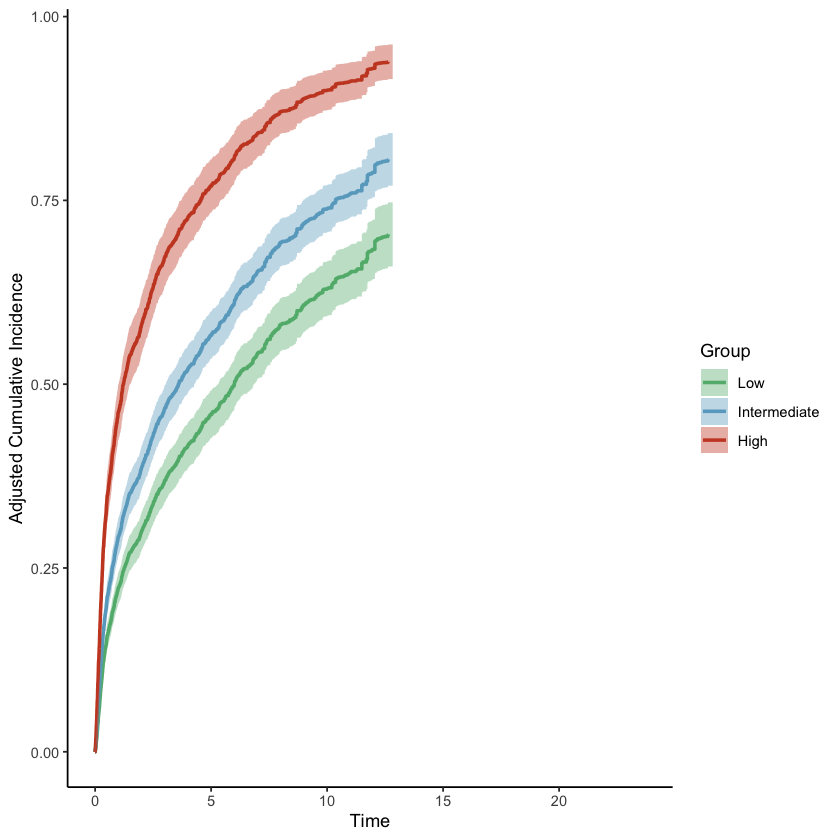

In [57]:
plot(clust.adjsurv, conf_int=TRUE, custom_colors=c("#62b67d","#69a9c8","#ca4a29"), cif=T)

In [48]:
pdf("figures/adjusted_surv_clust.pdf")
plot(clust.adjsurv, conf_int=TRUE, custom_colors=c("#62b67d","#69a9c8","#ca4a29"), cif=T) + xlim(0,15)
dev.off()

Loading required namespace: pammtools

Warning message:
“Removed 237 rows containing missing values (`geom_step()`).”


pdf 
  2

In [49]:
clust.adjci <- clust.adjsurv
clust.adjci$adjsurv$surv <- 1-clust.adjci$adjsurv$surv

times.to.use <- c(1,5,10)

cd.df <- adjusted_curve_diff(clust.adjci, times=times.to.use, group_1="Intermediate", group_2="Low", conf_int=TRUE)
cd.df$group <- "Intermediate vs. Low"

cd.2.df <- adjusted_curve_diff(clust.adjci, times=times.to.use, group_1="High", group_2="Intermediate", conf_int=TRUE)
cd.2.df$group <- "High vs. Intermediate"

cd.3.df <- adjusted_curve_diff(clust.adjci, times=times.to.use, group_1="High", group_2="Low", conf_int=TRUE)
cd.3.df$group <- "High vs. Low"

cd.df <- rbind(cd.df,cd.2.df,cd.3.df)

In [50]:
cd.df

time,diff,se,ci_lower,ci_upper,p_value,group
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,0.06956424,0.01713106,0.03598798,0.1031405,4.892409e-05,Intermediate vs. Low
5,0.10788219,0.02335398,0.06210923,0.1536551,3.847871e-06,Intermediate vs. Low
10,0.10879871,0.02508439,0.05963421,0.1579632,1.442389e-05,Intermediate vs. Low
1,0.16953039,0.02337985,0.12370672,0.2153541,4.133050e-13,High vs. Intermediate
5,0.20289396,0.02470979,0.15446365,0.2513243,2.192177e-16,High vs. Intermediate
10,0.16098493,0.02147217,0.11890025,0.2030696,6.510814e-14,High vs. Intermediate
1,0.23909462,0.02224548,0.19549427,0.2826950,6.055603e-27,High vs. Low
5,0.31077615,0.02477874,0.26221071,0.3593416,4.394918e-36,High vs. Low
10,0.26978364,0.02345498,0.22381272,0.3157546,1.286105e-30,High vs. Low


In [56]:
clust.adjsurv

Confounder Adjusted Survival Probabilities 
   - Method: Direct Standardization
   - Times: Event-Specific Times
   - Bootstrapping: Performed with 1000 Replications
   - Approximate CI: Calculated with a confidence level of 0.95
   - Using a single dataset

In [55]:
adj_test <- adjusted_curve_test(clust.adjsurv, from=0, to=15)
summary(adj_test)

------------------------------------------------------------------
   Test of the Difference between two adjusted Survival Curves
------------------------------------------------------------------

Using the interval: 0 to 15 

                      ABC ABC SE 95% CI (lower) 95% CI (upper) P-Value N Boot
Low vs. Intermediate   NA     NA             NA             NA     NaN      0
Low vs. High           NA     NA             NA             NA     NaN      0
Intermediate vs. High  NA     NA             NA             NA     NaN      0
------------------------------------------------------------------


In [52]:
pdf("figures/adjusted_surv_clustdiff_intermediate_low.pdf")
plot_curve_diff(clust.adjci, group_1="Intermediate", group_2="Low", conf_int=TRUE, color="blue") + ylim(0,0.25)
dev.off()

pdf 
  2

In [53]:
pdf("figures/adjusted_surv_clustdiff_high_low.pdf")
plot_curve_diff(clust.adjci, group_1="High", group_2="Low", conf_int=TRUE, color="red")
dev.off()

pdf 
  2

In [54]:
pdf("figures/adjusted_surv_clustdiff_high_intermediate.pdf")
plot_curve_diff(clust.adjci, group_1="High", group_2="Intermediate", conf_int=TRUE, color="red")
dev.off()

pdf 
  2

## 5. ESKD Prediction
---

In [181]:
eskd.df <- read.table("data/processed/treatment_eskd.tsv", sep="\t", header=T, row.names="Code.ID")
eskd.df <- eskd.df[rownames(data.df),]
eskd.df <- cbind(data.df, eskd.df[,c("RRT.Type","treatment_eskd","time_to_eskd","time_to_eskd_from_admission")])
eskd.df <- eskd.df[complete.cases(eskd.df$time_to_eskd),]

In [182]:
table(eskd.df$treatment_eskd)


   0    1 
1743  320 

In [183]:
table(eskd.df$treatment_eskd, eskd.df$cluster)

   
    Low Intermediate High
  0 598          623  522
  1  89          193   38

In [184]:
table(eskd.df$treatment_eskd, eskd.df$Renal.Stage..Palladini.)

   
        Stage I Stage II Stage III
  0 244     767      586       146
  1  20      23      193        84

In [185]:
eskd.fit.1 <- coxph(Surv(time_to_eskd_from_admission, treatment_eskd) ~ LC.Isotype + Age + Sex + Race + Era, data = eskd.df)
eskd.fit.2 <- update(eskd.fit.1, . ~ . + cluster)
eskd.fit.3 <- update(eskd.fit.1, . ~ . + Renal.Stage..Palladini.)
eskd.fit.4 <- update(eskd.fit.1, . ~ . + cluster + Renal.Stage..Palladini.)
eskd.fit.5 <- update(eskd.fit.1, . ~ . + cluster*Renal.Stage..Palladini.)

# with BU Cardiac Stage
eskd.fit.6 <- update(eskd.fit.1, . ~ . + BU.Cardiac.Stage)
eskd.fit.7 <- update(eskd.fit.1, . ~ . + cluster + BU.Cardiac.Stage)
eskd.fit.8 <- update(eskd.fit.1, . ~ . + cluster*BU.Cardiac.Stage)

# All 3
eskd.fit.9 <- update(eskd.fit.1, . ~ . + cluster+Renal.Stage..Palladini.+BU.Cardiac.Stage)
eskd.fit.10 <- update(eskd.fit.1, . ~ . + Renal.Stage..Palladini.+BU.Cardiac.Stage)
eskd.fit.11 <- update(eskd.fit.1, . ~ . + Renal.Stage..Palladini.*BU.Cardiac.Stage)

eskd.cdf <- data.frame(rbind(eskd.fit.1$concordance,
                            eskd.fit.2$concordance, 
                            eskd.fit.3$concordance, 
                            eskd.fit.4$concordance,
                            eskd.fit.5$concordance,
                            eskd.fit.6$concordance, 
                            eskd.fit.7$concordance, 
                            eskd.fit.8$concordance,
                            eskd.fit.9$concordance,
                            eskd.fit.10$concordance, 
                            eskd.fit.11$concordance, 
                           ))

Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  7,8 ; coefficient may be infinite. ”
Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  7,8 ; coefficient may be infinite. ”
Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  7,8,10,15,17,19 ; coefficient may be infinite. ”
Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  7,8 ; coefficient may be infinite. ”
Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  7,8 ; coefficient may be infinite. ”
Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  7,8,13,14,19,20,22,23 ; coefficient may be infinite. ”


Warning message in .get_data(model, data = data):
“The `data` argument is not provided. Data will be extracted from model fit.”


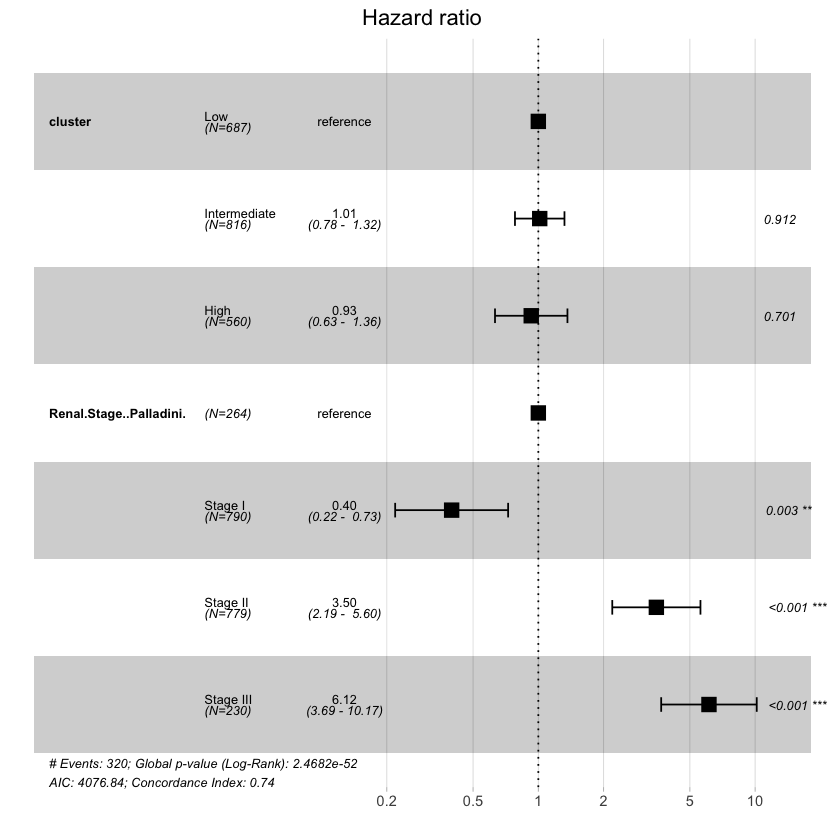

In [33]:
ggforest(eskd.fit.4)

In [30]:

# With BU Cardiac staging & cluster
# BU Cardiac staging is exposure
# We want to find absolute risk of death at 5, 10 years with adjusted Survival package
# Then do this with our clusters (without BU Cardiac Staging)
# Now if you find BU Cardiac stage II vs. clusters, then you can show you are capturing more

# Primary aim to decipher novel clusters
# Do they perform as good or capture something new


[1] 2.433949

In [ ]:
# Death ~ BU.Cardiac.Stage
# 

Warning message in .get_data(model, data = data):
“The `data` argument is not provided. Data will be extracted from model fit.”


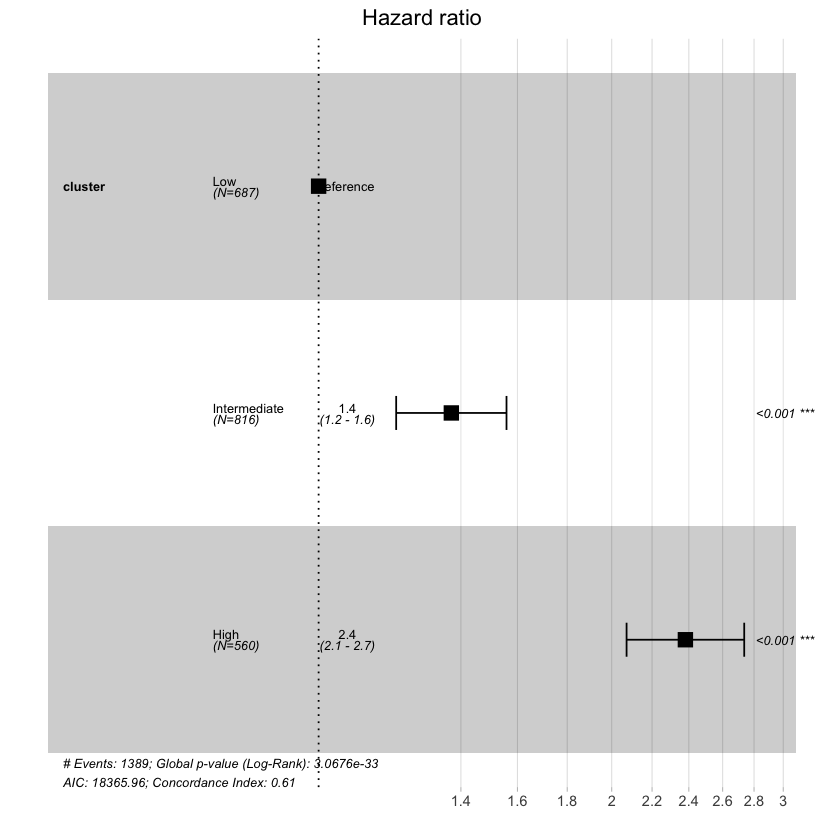

In [39]:
fit <- coxph(Surv(time_from_admission, status) ~ cluster, data = eskd.df)
ggforest(fit)

Warning message in .get_data(model, data = data):
“The `data` argument is not provided. Data will be extracted from model fit.”


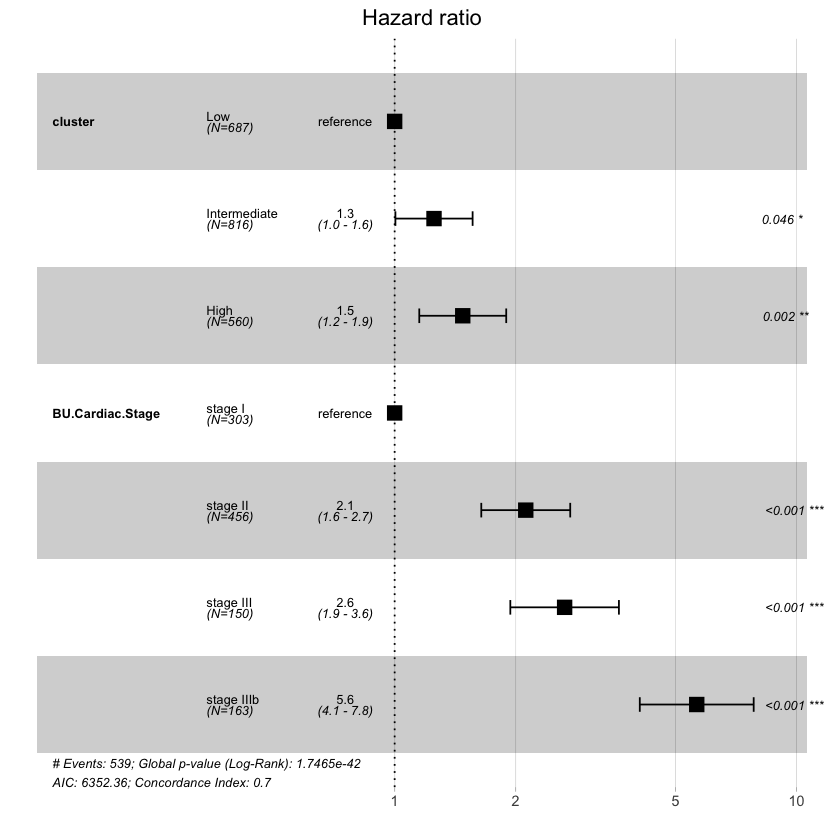

In [40]:
fit <- coxph(Surv(time_from_admission, status) ~ cluster + BU.Cardiac.Stage, data = eskd.df)
ggforest(fit)

Warning message in .get_data(model, data = data):
“The `data` argument is not provided. Data will be extracted from model fit.”


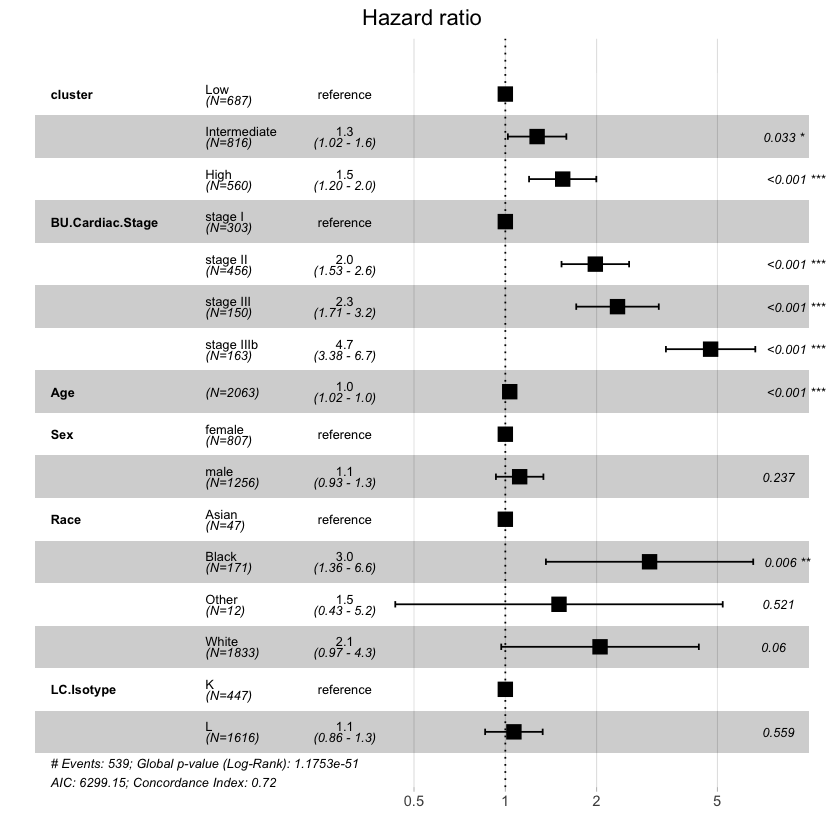

In [44]:
fit <- coxph(Surv(time_from_admission, status) ~ cluster + BU.Cardiac.Stage + Age + Sex + Race + LC.Isotype, data = eskd.df)
ggforest(fit)

Warning message in .get_data(model, data = data):
“The `data` argument is not provided. Data will be extracted from model fit.”


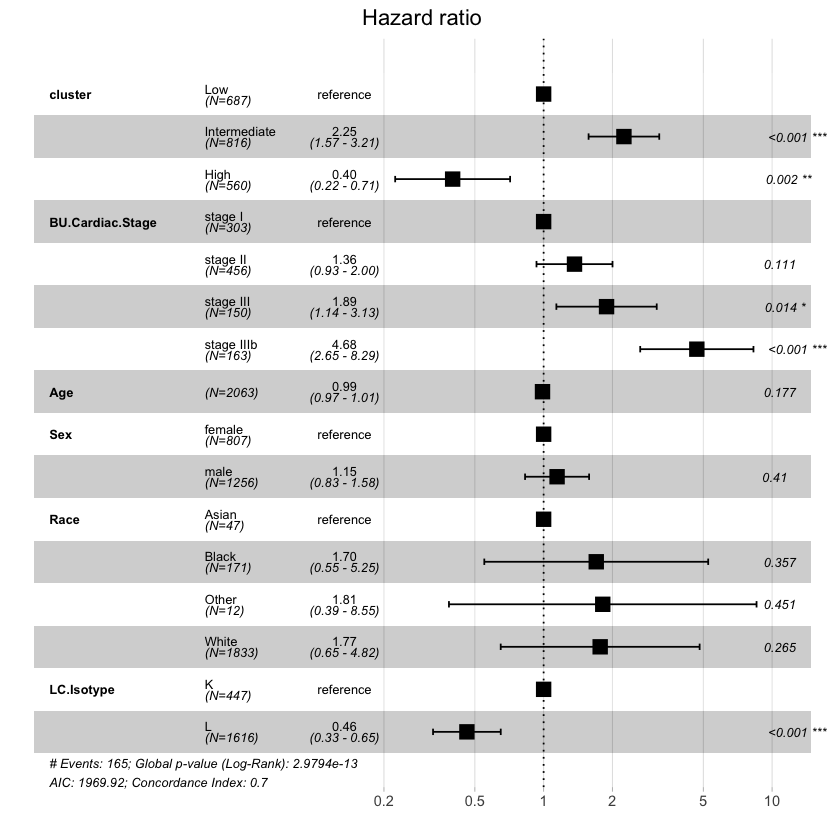

In [45]:
fit <- coxph(Surv(time_to_eskd_from_admission, treatment_eskd) ~ cluster + BU.Cardiac.Stage + Age + Sex + Race + LC.Isotype, data = eskd.df)
ggforest(fit)

Warning message in .get_data(model, data = data):
“The `data` argument is not provided. Data will be extracted from model fit.”


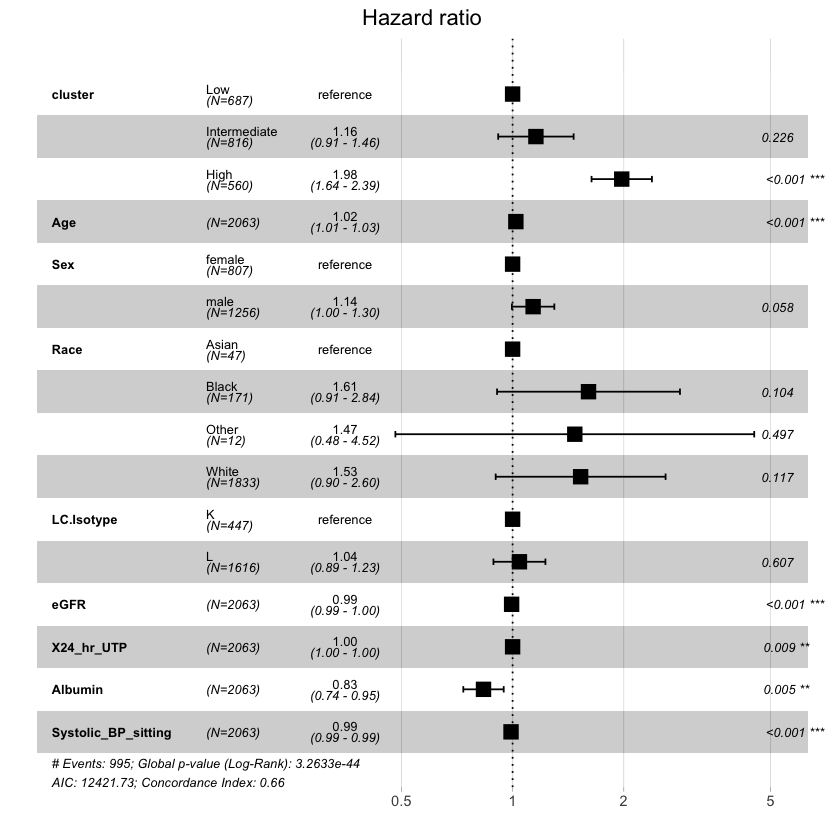

In [53]:
fit <- coxph(Surv(time_from_admission, status) ~ cluster + Age + Sex + 
             Race + LC.Isotype + eGFR + X24_hr_UTP + Albumin + Systolic_BP_sitting, data = eskd.df)
ggforest(fit)

Warning message in .get_data(model, data = data):
“The `data` argument is not provided. Data will be extracted from model fit.”


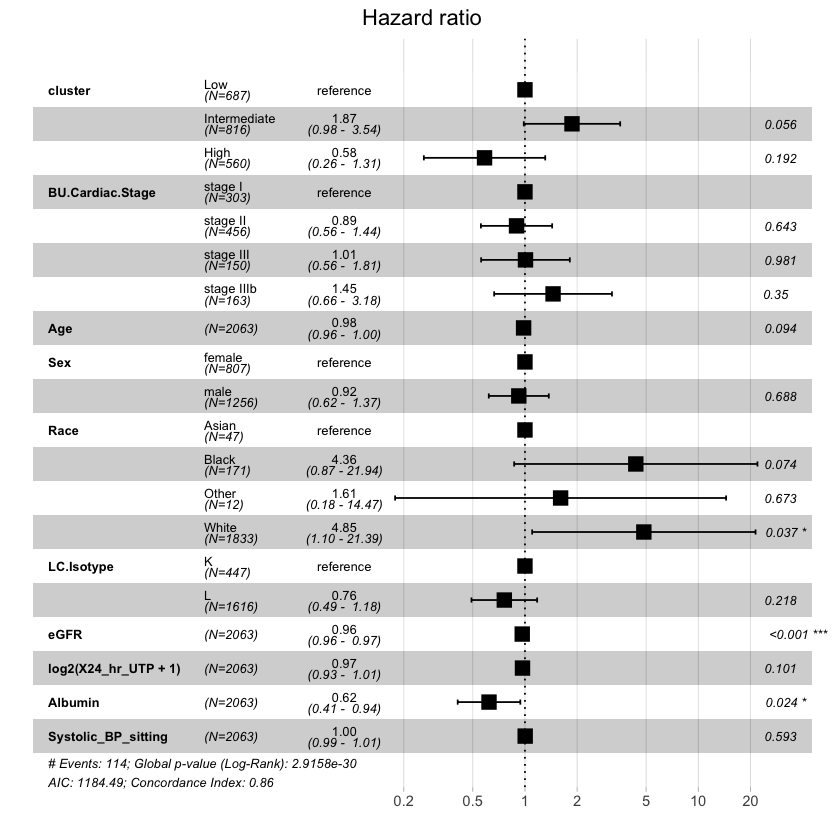

In [84]:
fit <- coxph(Surv(time_to_eskd_from_admission, treatment_eskd) ~ cluster + BU.Cardiac.Stage + Age + Sex + 
             Race + LC.Isotype + eGFR + log2(X24_hr_UTP+1) + Albumin + Systolic_BP_sitting, data = eskd.df)
ggforest(fit)

Warning message in .get_data(model, data = data):
“The `data` argument is not provided. Data will be extracted from model fit.”


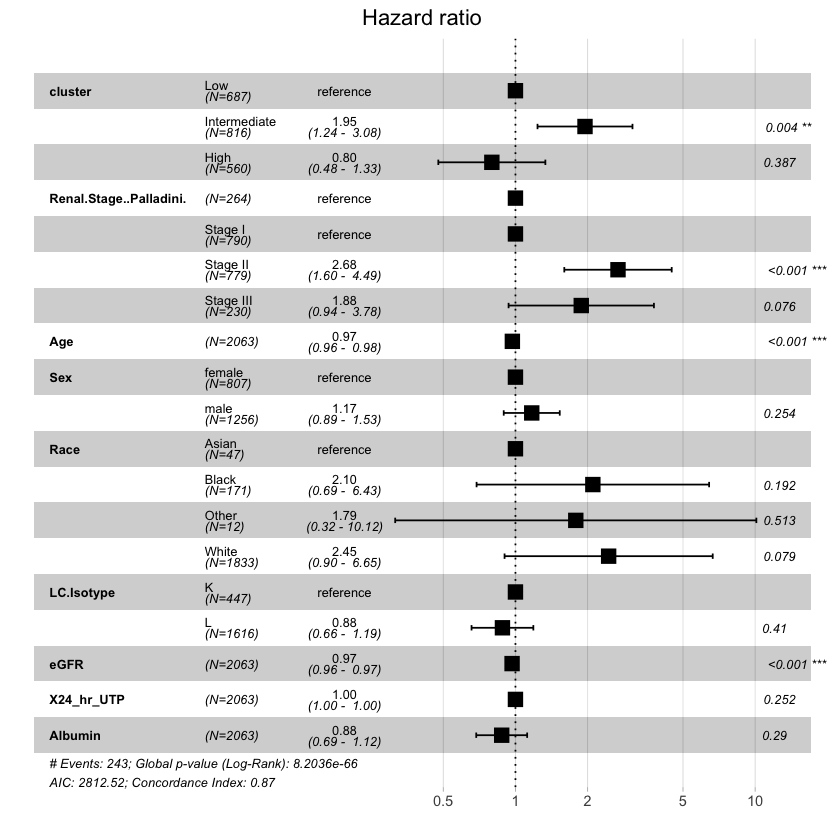

In [105]:
fit <- coxph(Surv(time_to_eskd_from_admission, treatment_eskd) ~ cluster + Renal.Stage..Palladini. + Age + Sex + 
             Race + LC.Isotype + eGFR + X24_hr_UTP + Albumin, data = eskd.df)
ggforest(fit)

Warning message in .get_data(model, data = data):
“The `data` argument is not provided. Data will be extracted from model fit.”


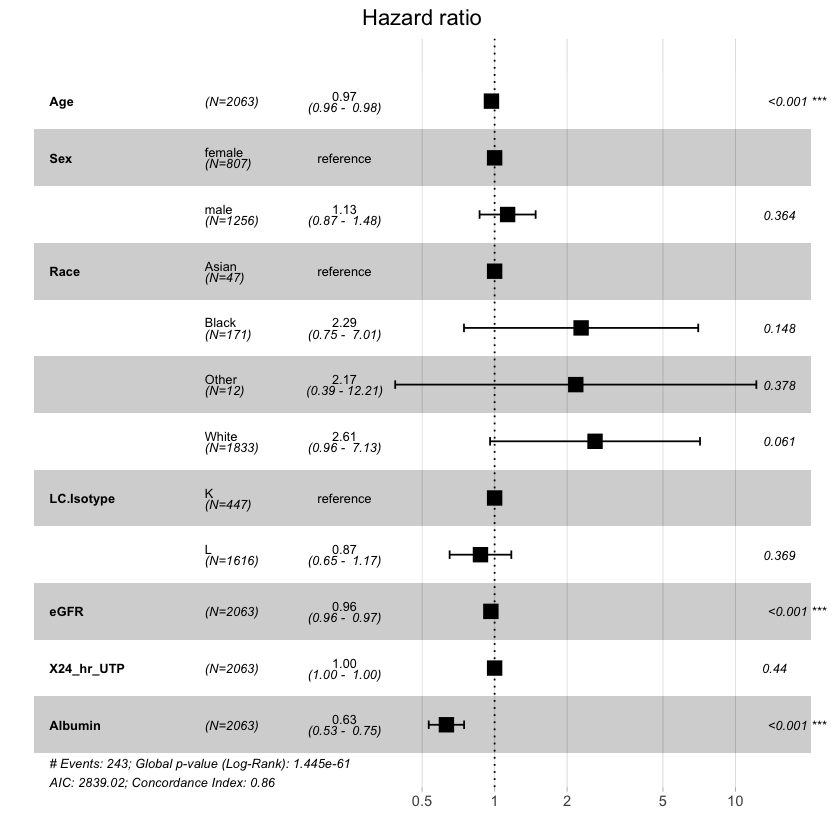

In [72]:
fit <- coxph(Surv(time_to_eskd_from_admission, treatment_eskd) ~ Age + Sex + 
             Race + LC.Isotype + eGFR + X24_hr_UTP+ + Albumin, data = eskd.df)
ggforest(fit)

In [19]:
eskd.fit.1$concordance
print(formula(eskd.fit.2))
eskd.fit.2$concordance
print(formula(eskd.fit.3))
eskd.fit.3$concordance
print(formula(eskd.fit.4))
eskd.fit.4$concordance
print(formula(eskd.fit.5))
eskd.fit.5$concordance
print(formula(eskd.fit.6))
eskd.fit.6$concordance
print(formula(eskd.fit.7))
eskd.fit.7$concordance
print(formula(eskd.fit.8))
eskd.fit.8$concordance
print(formula(eskd.fit.9))
eskd.fit.9$concordance
print(formula(eskd.fit.10))
eskd.fit.10$concordance
print(formula(eskd.fit.11))
eskd.fit.11$concordance

concordant   discordant       tied.x       tied.y      tied.xy  concordance 
2.196370e+05 1.478420e+05 2.461000e+03 1.700000e+01 0.000000e+00 5.970360e-01 
         std 
1.891959e-02

Surv(time_to_eskd_from_admission, treatment_eskd) ~ LC.Isotype + 
    Age + Sex + Race + cluster


concordant  discordant      tied.x      tied.y     tied.xy concordance 
2.36237e+05 1.32784e+05 9.19000e+02 1.70000e+01 0.00000e+00 6.39824e-01 
        std 
1.73799e-02

Surv(time_to_eskd_from_admission, treatment_eskd) ~ LC.Isotype + 
    Age + Sex + Race + Renal.Stage..Palladini.


concordant   discordant       tied.x       tied.y      tied.xy  concordance 
2.876460e+05 8.159900e+04 6.950000e+02 1.700000e+01 0.000000e+00 7.784871e-01 
         std 
1.114666e-02

Surv(time_to_eskd_from_admission, treatment_eskd) ~ LC.Isotype + 
    Age + Sex + Race + cluster + Renal.Stage..Palladini.


concordant   discordant       tied.x       tied.y      tied.xy  concordance 
2.876020e+05 8.201200e+04 3.260000e+02 1.700000e+01 0.000000e+00 7.778694e-01 
         std 
1.114299e-02

Surv(time_to_eskd_from_admission, treatment_eskd) ~ LC.Isotype + 
    Age + Sex + Race + cluster + Renal.Stage..Palladini. + cluster:Renal.Stage..Palladini.


concordant   discordant       tied.x       tied.y      tied.xy  concordance 
2.885230e+05 8.109100e+04 3.260000e+02 1.700000e+01 0.000000e+00 7.803590e-01 
         std 
1.129062e-02

Surv(time_to_eskd_from_admission, treatment_eskd) ~ LC.Isotype + 
    Age + Sex + Race + BU.Cardiac.Stage


concordant   discordant       tied.x       tied.y      tied.xy  concordance 
6.697300e+04 3.517200e+04 1.770000e+02 4.000000e+00 0.000000e+00 6.553967e-01 
         std 
2.295038e-02

Surv(time_to_eskd_from_admission, treatment_eskd) ~ LC.Isotype + 
    Age + Sex + Race + cluster + BU.Cardiac.Stage


concordant   discordant       tied.x       tied.y      tied.xy  concordance 
7.193800e+04 3.030500e+04 7.900000e+01 4.000000e+00 0.000000e+00 7.034411e-01 
         std 
2.261175e-02

Surv(time_to_eskd_from_admission, treatment_eskd) ~ LC.Isotype + 
    Age + Sex + Race + cluster + BU.Cardiac.Stage + cluster:BU.Cardiac.Stage


concordant   discordant       tied.x       tied.y      tied.xy  concordance 
7.259900e+04 2.964400e+04 7.900000e+01 4.000000e+00 0.000000e+00 7.099011e-01 
         std 
2.223402e-02

Surv(time_to_eskd_from_admission, treatment_eskd) ~ LC.Isotype + 
    Age + Sex + Race + cluster + Renal.Stage..Palladini. + BU.Cardiac.Stage


concordant   discordant       tied.x       tied.y      tied.xy  concordance 
8.204600e+04 2.024800e+04 2.800000e+01 4.000000e+00 0.000000e+00 8.019781e-01 
         std 
1.485176e-02

Surv(time_to_eskd_from_admission, treatment_eskd) ~ LC.Isotype + 
    Age + Sex + Race + Renal.Stage..Palladini. + BU.Cardiac.Stage


concordant   discordant       tied.x       tied.y      tied.xy  concordance 
8.242600e+04 1.983400e+04 6.200000e+01 4.000000e+00 0.000000e+00 8.058580e-01 
         std 
1.457787e-02

Surv(time_to_eskd_from_admission, treatment_eskd) ~ LC.Isotype + 
    Age + Sex + Race + Renal.Stage..Palladini. + BU.Cardiac.Stage + 
    Renal.Stage..Palladini.:BU.Cardiac.Stage


concordant   discordant       tied.x       tied.y      tied.xy  concordance 
8.299100e+04 1.926900e+04 6.200000e+01 4.000000e+00 0.000000e+00 8.113798e-01 
         std 
1.387522e-02

Warning message in .get_data(model, data = data):
“The `data` argument is not provided. Data will be extracted from model fit.”


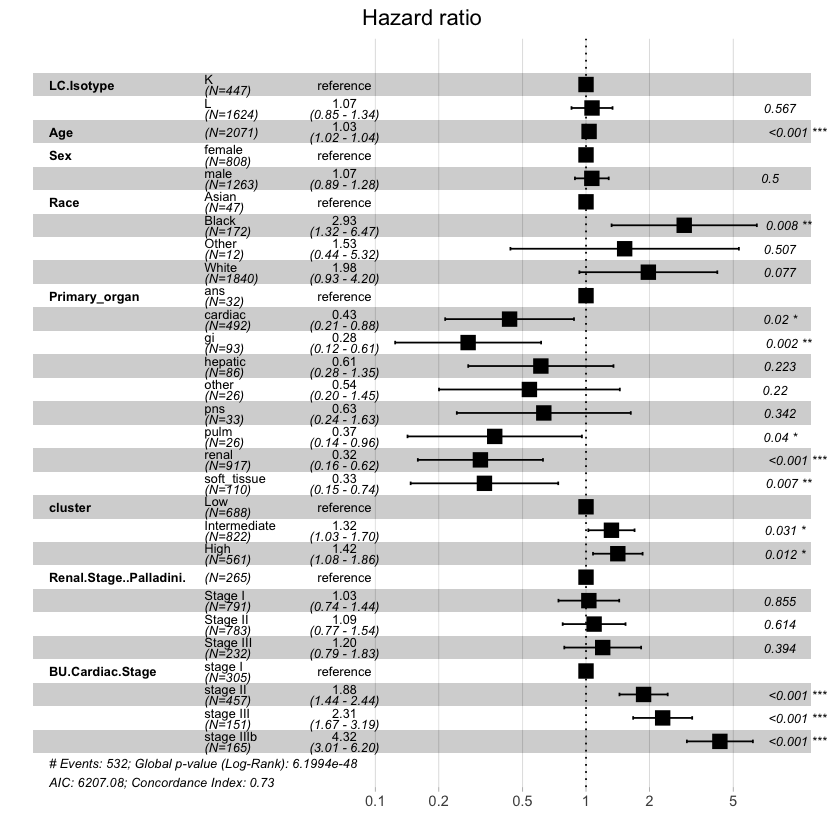

In [88]:
ggforest(eskd.fit.6)

Warning message in .get_data(model, data = data):
“The `data` argument is not provided. Data will be extracted from model fit.”


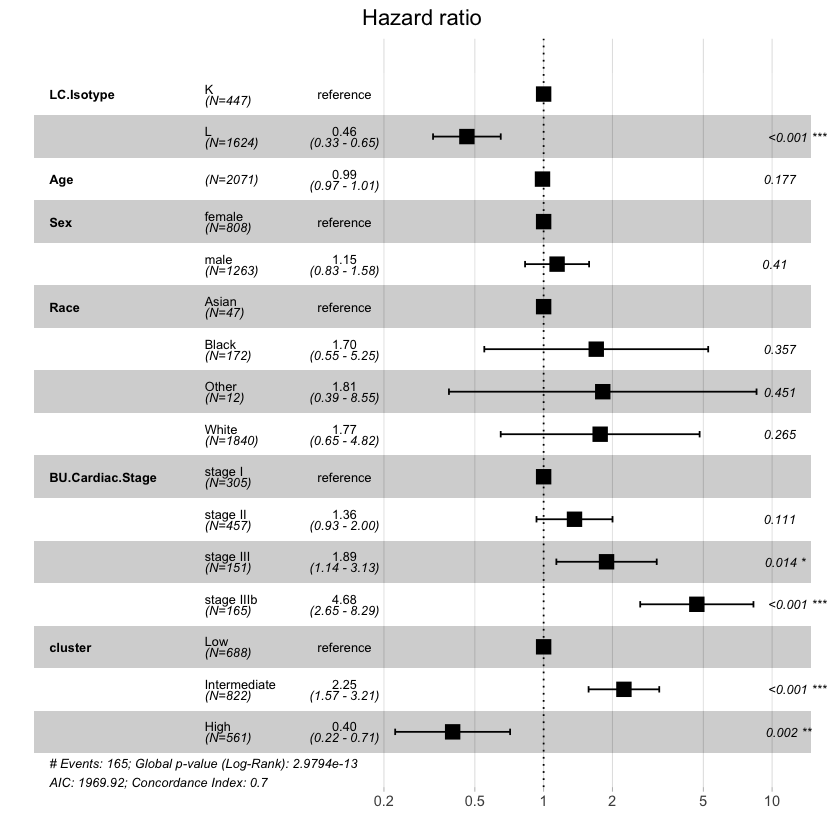

In [70]:
eskd.fit <- coxph(Surv(time_to_eskd_from_admission, treatment_eskd) ~ 
                  LC.Isotype + Age + Sex + Race + BU.Cardiac.Stage + cluster, data = eskd.df, x=TRUE)

ggforest(eskd.fit)

Warning message in .get_data(model, data = data):
“The `data` argument is not provided. Data will be extracted from model fit.”


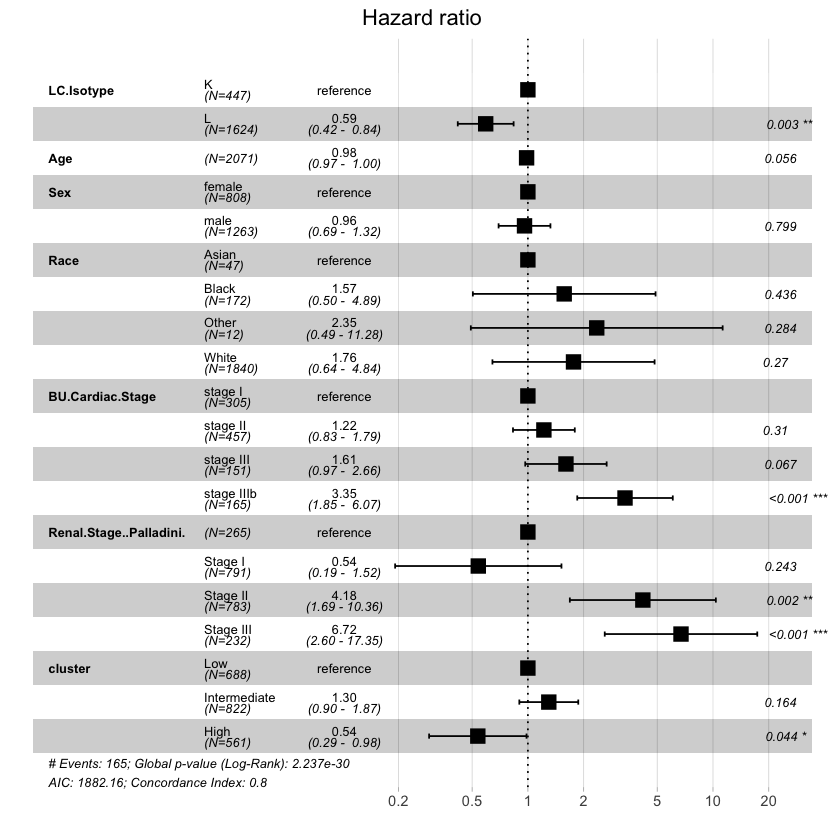

In [62]:
eskd.fit <- coxph(Surv(time_to_eskd_from_admission, treatment_eskd) ~ 
                  LC.Isotype + Age + Sex + Race + BU.Cardiac.Stage + Renal.Stage..Palladini.+cluster, data = eskd.df, x=TRUE)
a
ggforest(eskd.fit)

In [22]:
log.mod <- glm(eskd ~ LC.Isotype + Age + Sex + Race + Troponin + eGFR +
             Primary_organ + Era + BU.Cardiac.Stage + cluster , family=binomial(link="logit"), data=data.df)

In [23]:
summary(log.mod)


Call:
glm(formula = eskd ~ LC.Isotype + Age + Sex + Race + Troponin + 
    eGFR + Primary_organ + Era + BU.Cardiac.Stage + cluster, 
    family = binomial(link = "logit"), data = data.df)

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)    
(Intercept)                -1.578e+01  3.865e+03  -0.004   0.9967    
LC.IsotypeL                -1.115e-01  2.476e-01  -0.450   0.6524    
Age                        -3.598e-02  1.103e-02  -3.263   0.0011 ** 
Sexmale                     1.561e-01  2.203e-01   0.708   0.4787    
RaceBlack                  -4.940e-01  7.340e-01  -0.673   0.5009    
RaceOther                  -1.142e+00  1.530e+00  -0.746   0.4555    
RaceWhite                  -1.052e-01  6.551e-01  -0.161   0.8724    
Troponin                   -2.636e-01  4.748e-01  -0.555   0.5787    
eGFR                       -3.598e-02  3.964e-03  -9.075  < 2e-16 ***
Primary_organcardiac       -6.853e-02  1.175e+00  -0.058   0.9535    
Primary_organgi           

In [25]:
log.mod <- glm(eskd ~ LC.Isotype + Age + Race + Sex + Troponin + Primary_organ + cluster*eGFR + 
               cluster*X24_hr_UTP + cluster*Albumin, family=binomial(link="logit"), data=data.df)

summary(log.mod)


Call:
glm(formula = eskd ~ LC.Isotype + Age + Race + Sex + Troponin + 
    Primary_organ + cluster * eGFR + cluster * X24_hr_UTP + cluster * 
    Albumin, family = binomial(link = "logit"), data = data.df)

Coefficients:
                                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)                     5.951e+00  2.646e+00   2.249   0.0245 *  
LC.IsotypeL                    -2.000e-01  2.956e-01  -0.677   0.4987    
Age                            -2.969e-02  1.271e-02  -2.336   0.0195 *  
RaceBlack                      -1.119e-01  8.218e-01  -0.136   0.8917    
RaceOther                      -5.150e-01  1.500e+00  -0.343   0.7313    
RaceWhite                       1.521e-01  7.333e-01   0.207   0.8357    
Sexmale                         1.313e-01  2.491e-01   0.527   0.5980    
Troponin                        6.976e-02  3.567e-01   0.196   0.8449    
Primary_organcardiac            2.031e-03  1.189e+00   0.002   0.9986    
Primary_organgi                 8.914e